**Data Engineering and Estimator Competition Implementations**

In [1]:
# Library imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from prettytable import PrettyTable

In [2]:
# Read data
url = 'https://raw.githubusercontent.com/arjayit/cs4432_data/master/bike_share_hour.csv'
df = pd.read_csv(url)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


*Part 1  - Data Exploration*

In [3]:
# Convert the columns that are categorical to a pandas “category” type.
# The columns which are natively categorical in nature are season, weekday, and weathersit
# However, holiday and workingday are functioning as boolean T/f classifiers, and may therefore also be cast as categorical
# The yr, mnth, and hr columns are corner cases - depending on use case you could represent these data as numerical or categorical
# I'm going to treat them as categorical
# The 'dteday' column is already object-type, but I'll convert it anyway
cat_cols = ['season', 'weekday', 'weathersit', 'holiday', 'workingday', 'yr', 'mnth', 'hr', 'dteday']
df[cat_cols] = df[cat_cols].astype('category')
print(df.dtypes)

instant          int64
dteday        category
season        category
yr            category
mnth          category
hr            category
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object


In [4]:
# Look for non-null values in the dataset
print(df.notnull().sum())
print()
print(f'Total rows: {len(df)}')
# Conclusion: all columns have 17,379 non-null values and the dataframe is 17,379 rows long. There are no null values present.

instant       17379
dteday        17379
season        17379
yr            17379
mnth          17379
hr            17379
holiday       17379
weekday       17379
workingday    17379
weathersit    17379
temp          17379
atemp         17379
hum           17379
windspeed     17379
casual        17379
registered    17379
cnt           17379
dtype: int64

Total rows: 17379


In [5]:
# Run a descriptive analysis of the numeric columns.
df.describe().round(2)  # Because long decimal values are unpleasant to read

,instant,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,8690.00,0.50,0.48,0.63,0.19,35.68,153.79,189.46
std,5017.03,0.19,0.17,0.19,0.12,49.31,151.36,181.39
min,1.00,0.02,0.00,0.00,0.00,0.00,0.00,1.00
25%,4345.50,0.34,0.33,0.48,0.10,4.00,34.00,40.00
50%,8690.00,0.50,0.48,0.63,0.19,17.00,115.00,142.00
75%,13034.50,0.66,0.62,0.78,0.25,48.00,220.00,281.00
max,17379.00,1.00,1.00,1.00,0.85,367.00,886.00,977.00


<Axes: xlabel='season', ylabel='cnt'>

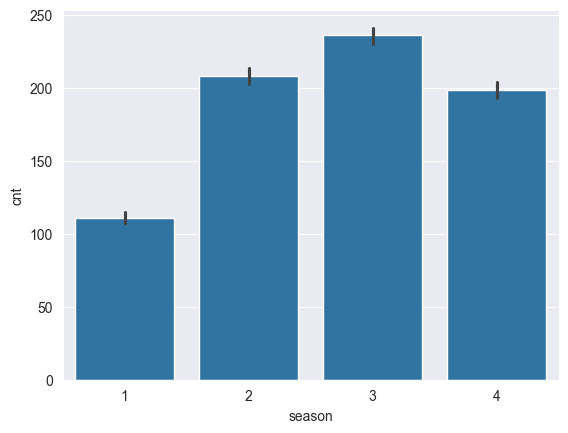

In [6]:
# Implement a bar plot of cnt versus season. Document which season has the most bike rides and which season has the least.
sns.barplot(data=df, x='season', y='cnt')
# Conclusion: Season 3 has the most bike rides. Season 1 has the fewest.

<Axes: xlabel='workingday', ylabel='cnt'>

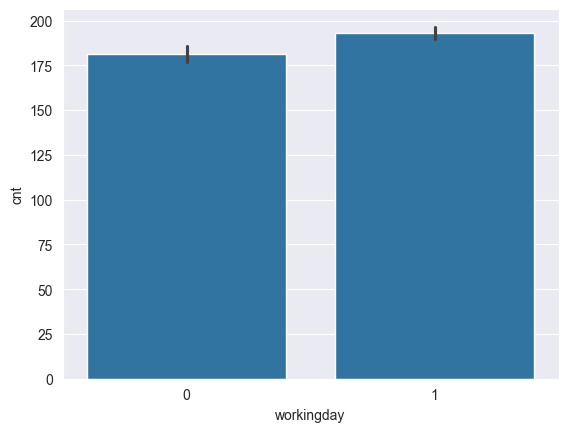

In [7]:
# Implement a bar chart for working day versus count. Document how bike rides are distributed across these two classes.
sns.barplot(data=df, x='workingday', y='cnt')
# Conclusion: while the distribution is not especially asymmetric, the mean number of bike rides taken on working days is slightly higher than the mean number of bike rides taken on non-working days.

<Axes: xlabel='mnth', ylabel='cnt'>

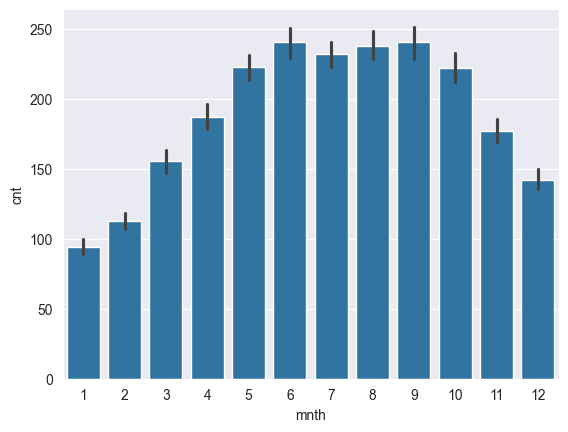

In [8]:
# Implement a bar chart for month versus count. Document which months have the most bike rides.
sns.barplot(data=df, x='mnth', y='cnt')
# Conclusion: The months with the highest average number of bike rides are months 6 and 9.

In [9]:
# Implement code to figure out which months belong to which seasons.
# Group by season and aggregate by month to get only unique values. Limit to values observed in the data.
months_by_season = df.groupby('season', observed=True)['mnth'].unique().reset_index()

# Converting from np arrays to lists using apply()
months_by_season['mnth'] = months_by_season['mnth'].apply(list)
months_by_season

,season,mnth
0,1,"[1, 2, 3, 12]"
1,2,"[3, 4, 5, 6]"
2,3,"[6, 7, 8, 9]"
3,4,"[9, 10, 11, 12]"


weathersit
1    11413
2     4544
3     1419
4        3
dtype: int64


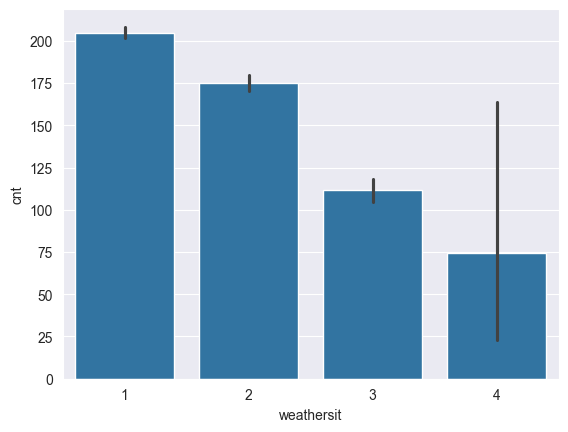

In [10]:
# Implement a bar plot of weathersit versus cnt. Document which weather situation has less bike rentals.
sns.barplot(data=df, x='weathersit', y='cnt')
# Conclusion: Weather situation 4 ('Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog' per the dox) has the lowest number of rentals on average, but also has a very large error bar.
# This implies high variability in this category, likely due to small row count within that category
print(df.groupby(df['weathersit'], observed=True).size())  # Confirmed

<Axes: xlabel='weathersit', ylabel='cnt'>

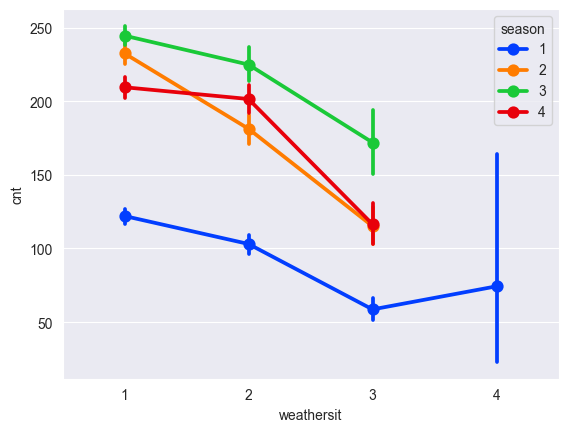

In [11]:
# Implement a point plot of weathersit on the x-axis, count on the y-axis, and the season as the hue. Document how season and weathersit are related.
sns.pointplot(data=df, x='weathersit', y='cnt', hue='season', palette='bright')
# Conclusion: In all seasons, as the weather gets worse, (which in this context is indicated by the value for 'weathersit' increasing) the number of rentals decreases.
# Within season 4, a change in weathersit value from 1 to 2 did not show as notable a decrease in bike rentals as is the case in other seasons
# There is no representation/observations of weathersit 4 in any season other than season 1. Given the plot, season 1 appears to have the 'worst' weather and fewest rentals.
# More rides are taken in season 3 (given the same weather) than in other seasons

<Axes: xlabel='hr', ylabel='cnt'>

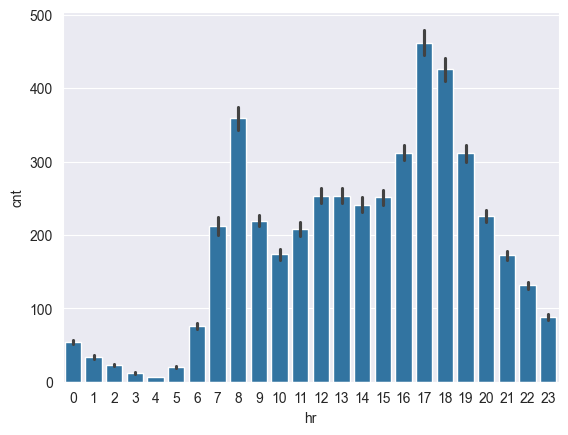

In [12]:
# Implement a bar plot of hour versus count. Are there any specific hours that are busier than others?
sns.barplot(data=df, x='hr', y='cnt')
# Conclusion: On average, the busiest hours are 8 AM (hr=8), 5 PM (hr=17), and 6 PM (hr=18). Note that we're considering 24-hour time values, here.
# (In other words, 6 PM is 18:00 or 'eighteen-hundred hours'.)
# This is logical. Bike rentals appear most common during the hour right before normal work hours begin and during the two hours after normal working hours end.

<Axes: xlabel='hr', ylabel='cnt'>

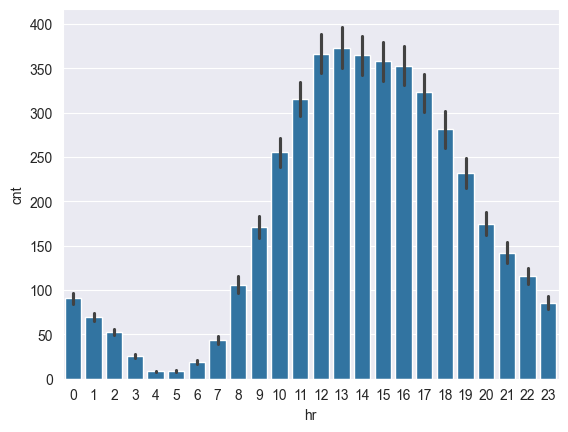

In [13]:
# Implement a bar plot of hour versus count on weekends and holidays (when workingday = 0). Does the hourly trend change on weekends?
weekend_df = df[df['workingday'] == 0]
sns.barplot(data=weekend_df, x='hr', y='cnt')
# Conclusion: Yes, the hourly trend changes dramatically on weekends and holidays. The most popular hours for bike rentals on weekends and holidays are the early- to mid-afternoon.
# In other words, on weekends and holidays, people are generally most likely to rent bikes between noon and 4 PM (1600 hours.) 

*Part 2 - Data Preparation*

<Axes: >

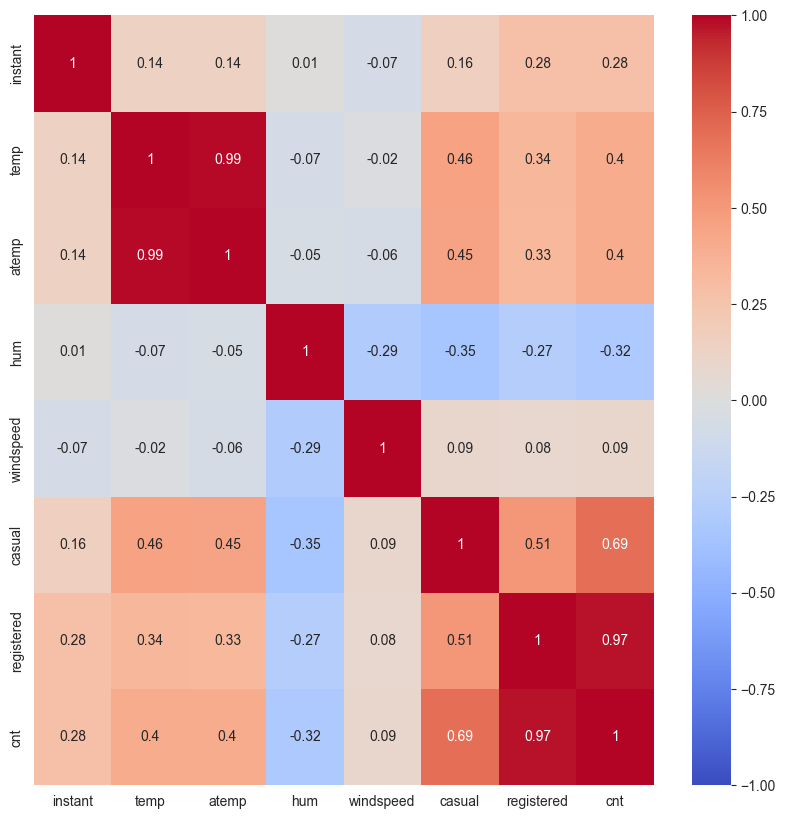

In [14]:
# Implement and graph a correlation matrix with the remaining numeric features. Are there any interesting relationships?
num_cols = [column for column in df.columns if column not in cat_cols]

# Subset the dataframe to include only numeric columns
num_df = df[num_cols]

# Create correlation matrix
corr_matrix = num_df.corr()

# Correlation matrix visualization
fig = plt.figure(figsize= (10, 10))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# Conclusions: 
# There's a notable positive correlation between temp and casual - as the weather gets warmer, the count of casual users gets higher
# There's also a notable positive correlation between temp and registered - as the weather gets warmer, the count of registered users gets higher
# In sum, warmer weather is correlated with more riders, both casual and registered
# Higher levels of humidity are negatively correlated with casual and registered - as the humidity gets higher, fewer people (of both 'user types') are renting bikes
# Unsurprisingly, registered users are renting bikes more often than casual users (note correlation values for cnt/registered and cnt/casual.)

In [15]:
# Define list of numeric columns excluding the target column, 'cnt'
num_feat_cols = ['instant', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']

In [16]:
# Scale the numerical features using StandardScaler(), and replace the original columns in your dataframe.
scaler = StandardScaler()  # Instantiate the scaler
df[num_feat_cols] = scaler.fit_transform(df[num_feat_cols])  # Scale only the numeric columns (excepting 'cnt') as defined above and directly reassign to dataframe
df.head(10)  # Sanity check

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,-1.731951,2011-01-01,1,0,1,0,0,6,0,1,-1.334648,-1.093281,0.947372,-1.553889,-0.662755,-0.930189,16
1,-1.731752,2011-01-01,1,0,1,1,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.561343,-0.804655,40
2,-1.731552,2011-01-01,1,0,1,2,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.622190,-0.837690,32
3,-1.731353,2011-01-01,1,0,1,3,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.662755,-0.950010,13
4,-1.731154,2011-01-01,1,0,1,4,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.723603,-1.009474,1
5,-1.730955,2011-01-01,1,0,1,5,0,6,0,2,-1.334648,-1.269602,0.636370,-0.821484,-0.723603,-1.009474,1
6,-1.730755,2011-01-01,1,0,1,6,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,-0.683038,-1.016081,2
7,-1.730556,2011-01-01,1,0,1,7,0,6,0,1,-1.542385,-1.269602,1.206542,-1.553889,-0.703320,-1.002867,3
8,-1.730357,2011-01-01,1,0,1,8,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,-0.703320,-0.969832,8
9,-1.730157,2011-01-01,1,0,1,9,0,6,0,1,-0.919172,-0.740638,0.688203,-1.553889,-0.561343,-0.976439,14


In [17]:
# Drop the following columns from the dataset: casual, registered, dteday, instant.
drop_cols = ['casual', 'registered', 'dteday', 'instant']  # Create list of columns to drop
df.drop(columns=drop_cols, inplace=True)  # Drop columns in place
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,-1.334648,-1.093281,0.947372,-1.553889,16
1,1,0,1,1,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,40
2,1,0,1,2,0,6,0,1,-1.438516,-1.181732,0.895539,-1.553889,32
3,1,0,1,3,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,13
4,1,0,1,4,0,6,0,1,-1.334648,-1.093281,0.636370,-1.553889,1


<Axes: xlabel='cnt', ylabel='Count'>

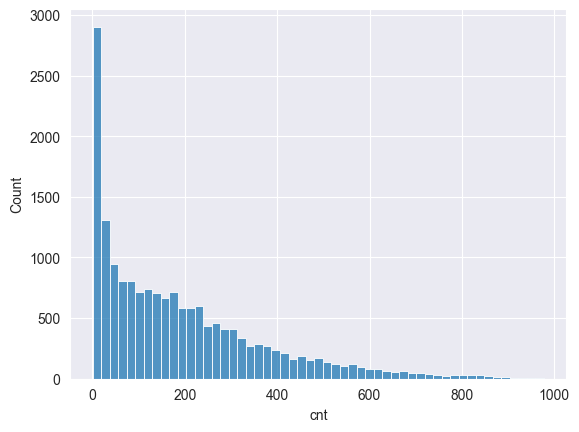

In [18]:
# Implement a histogram of the count column. What can be said based on the resulting distribution?
sns.histplot(data=df, x='cnt')
# The distribution is heavily skewed right.
# The plot implies that while there are hours with a large number of rentals, there are clearly many hours with a very small number of rentals

In [19]:
# Implement a train/test split with a test size of 33%.
feature_set = df.drop(columns=['cnt'])  # Build feature set
target_set = df['cnt']  # Build target set
feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.33, random_state=4)

In [20]:
# Implement a baseline linear regression algorithm. Use cross-validation to output R2 and mse. Calculate RMSE based on mse. Document your scores.
lin_model = LinearRegression()  # Instantiate model

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

# Perform cross-validation using five folds and passing the scoring dictionary. 
# No need to return training scores because I'm only interested in the cross-validated 'test' data.
cv_results = cross_validate(lin_model, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)

rmse_scores = np.sqrt(-cv_results['test_MSE'])  # Calculate RMSE score based on MSE

# Store R2 and MSE scores
r2_scores = cv_results['test_R2']
mse_scores = -cv_results['test_MSE']

# Output scores
print(f'R2: {r2_scores}')
print(f'MSE: {mse_scores}')
print(f'RMSE: {rmse_scores}')

# Take the mean values of the five scores for each metric
print()
print(f'Mean R2: {np.mean(r2_scores):.6f}')
print(f'Mean MSE: {np.mean(mse_scores):.6f}')
print(f'Mean RMSE: {np.mean(rmse_scores):.6f}')

R2: [0.38229795 0.39718005 0.38401588 0.36254666 0.37580405]
MSE: [20057.95907659 19075.6310868  20422.12936432 21207.52797249
 20595.32123855]
RMSE: [141.62612427 138.11455784 142.90601584 145.62804665 143.51070078]

Mean R2: 0.380369
Mean MSE: 20271.713748
Mean RMSE: 142.357089


*Part 3 - Model Training*

In [21]:
# Create one-hot-encoded values for all categorical columns using get_dummies and add them to the source dataset. Drop the original categorical columns from the source dataset. 
encode_cols = ['season', 'weekday', 'weathersit', 'holiday', 'workingday']
df = pd.get_dummies(df, columns=encode_cols, drop_first=False)  # Encode list of variables, replace in dataframe, do not delete first levels
df.head()  # Visual check

,yr,mnth,hr,temp,atemp,hum,windspeed,cnt,season_1,season_2,...,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,holiday_0,holiday_1,workingday_0,workingday_1
0,0,1,0,-1.334648,-1.093281,0.947372,-1.553889,16,True,False,...,False,True,True,False,False,False,True,False,True,False
1,0,1,1,-1.438516,-1.181732,0.895539,-1.553889,40,True,False,...,False,True,True,False,False,False,True,False,True,False
2,0,1,2,-1.438516,-1.181732,0.895539,-1.553889,32,True,False,...,False,True,True,False,False,False,True,False,True,False
3,0,1,3,-1.334648,-1.093281,0.636370,-1.553889,13,True,False,...,False,True,True,False,False,False,True,False,True,False
4,0,1,4,-1.334648,-1.093281,0.636370,-1.553889,1,True,False,...,False,True,True,False,False,False,True,False,True,False


In [22]:
# Do a test/train split based on the new source dataset. Implement and fit a new linear model on the new training set. What are the new values for r2, mse, and rmse?
# Re-declare feature and target sets
feature_set = df.drop(columns=['cnt'])
target_set = df['cnt']

feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.33, random_state=4)  # Using same parameters

lin_model = LinearRegression()  # Instantiate model

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

# Perform cross-validation using five folds and passing the scoring dictionary. 
# No need to return training scores because I'm only interested in the cross-validated 'test' data.
cv_results = cross_validate(lin_model, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)

rmse_scores = np.sqrt(-cv_results['test_MSE'])  # Calculate RMSE score based on MSE

# Store R2 and MSE scores
r2_scores = cv_results['test_R2']
mse_scores = -cv_results['test_MSE']

# Output scores
print(f'R2: {r2_scores}')
print(f'MSE: {mse_scores}')
print(f'RMSE: {rmse_scores}')

# Take the mean values of the five scores for each metric
print()
print(f'Mean R2: {np.mean(r2_scores):.6f}')
print(f'Mean MSE: {np.mean(mse_scores):.6f}')
print(f'Mean RMSE: {np.mean(rmse_scores):.6f}')

# Conclusion: The performance of the model has increased, but only very slightly.

R2: [0.39533146 0.40741561 0.39027189 0.37620963 0.38691748]
MSE: [19634.73619521 18751.73696246 20214.71977757 20752.97254573
 20228.6340839 ]
RMSE: [140.12400292 136.93698172 142.1784786  144.0589204  142.22740272]

Mean R2: 0.391229
Mean MSE: 19916.559913
Mean RMSE: 141.105157


In [23]:
# Implement and score a decision tree regressor with random_state=0.
# Implement and score a RandomForestRegressor with random_state=0 and n_esitmators=30.
# Implement and score an SGDRegressor with max_iter=1000 and tol=1e-3).
# Implement and score a Lasso Regressor with alpha=0.1.
# Implement and score an ElasticNet Regressor with random_state=0.
# Implement and score a Ridge Regressor with alpha=0.5.
# Implement and score a BaggingRegressor.

# I can make a list of tuples to store all the estimators and parameters that I want to run
estimators = [
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=0)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=0, n_estimators=30)),
    ('SGD Regressor', SGDRegressor(max_iter=1000, tol=1e-3)),
    ('Lasso Regressor', Lasso(alpha=0.1)),
    ('Elastic Net Regressor', ElasticNet(random_state=0)),
    ('Ridge Regressor', Ridge(alpha=0.5)),
    ('Bagging Regressor', BaggingRegressor(random_state=0))
]

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

score_table = PrettyTable()  # Instantiate the score table
score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']  # Define field names in table

for name, estimator in estimators:  # For each estimator name and estimator algorithm in the estimators list
    cv_results = cross_validate(estimator, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)  # Run cross_validate
    r2_scores = cv_results['test_R2']  # Store R2 scores
    mse_scores = -cv_results['test_MSE']  # Store MSE scores
    rmse_scores = np.sqrt(-cv_results['test_MSE'])  # Store RMSE scores
    
    # Add results for each estimator to the score table
    score_table.add_row([
        name, 
        f'{np.mean(r2_scores):.6f}', 
        f'{np.mean(mse_scores):.6f}', 
        f'{np.mean(rmse_scores):.6f}'])

print(score_table)

+-------------------------+----------+--------------+------------+
|          Model          | Mean R2  |   Mean MSE   | Mean RMSE  |
+-------------------------+----------+--------------+------------+
| Decision Tree Regressor | 0.884578 | 3772.168996  | 61.404239  |
| Random Forest Regressor | 0.937090 | 2057.020501  | 45.350476  |
|      SGD Regressor      | 0.377345 | 20368.762805 | 142.700556 |
|     Lasso Regressor     | 0.391241 | 19916.173742 | 141.103839 |
|  Elastic Net Regressor  | 0.348142 | 21326.460314 | 146.013499 |
|     Ridge Regressor     | 0.391231 | 19916.516287 | 141.105005 |
|    Bagging Regressor    | 0.931365 | 2244.280984  | 47.372906  |
+-------------------------+----------+--------------+------------+


*Part 4 - Model Tuning*

In [24]:
# Take the top three performing models and implement cross-validation
top_models = [
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=0)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=0, n_estimators=30)),
    ('Bagging Regressor', BaggingRegressor(random_state=0))]

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

score_table = PrettyTable()  # Instantiate the score table
score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']  # Define field names in table

for name, model in top_models:  # For each estimator name and estimator algorithm in the list of 'top' estimators
    cv_results = cross_validate(model, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)  # Run cross_validate
    r2_scores = cv_results['test_R2']  # Store R2 scores
    mse_scores = -cv_results['test_MSE']  # Store MSE scores
    rmse_scores = np.sqrt(-cv_results['test_MSE'])  # Store RMSE scores
    
    # Add results for each estimator to the score table
    score_table.add_row([
        name, 
        f'{np.mean(r2_scores):.6f}', 
        f'{np.mean(mse_scores):.6f}', 
        f'{np.mean(rmse_scores):.6f}'])

print(score_table)

+-------------------------+----------+-------------+-----------+
|          Model          | Mean R2  |   Mean MSE  | Mean RMSE |
+-------------------------+----------+-------------+-----------+
| Decision Tree Regressor | 0.884578 | 3772.168996 | 61.404239 |
| Random Forest Regressor | 0.937090 | 2057.020501 | 45.350476 |
|    Bagging Regressor    | 0.931365 | 2244.280984 | 47.372906 |
+-------------------------+----------+-------------+-----------+


In [25]:
# Take the top performing model and run a randomized search cv with 20 iterations and three folds.
random_forest_reg = RandomForestRegressor(random_state=0)  # Instantiate the regressor

params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(10, 110, 11).astype(int),
    'max_features': [None, 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': np.linspace(200, 2000, 10).astype(int)
    }

# Define randomized search
rand_search = RandomizedSearchCV(
    estimator=random_forest_reg,
    param_distributions=params,
    n_iter=20,  # Number of searches/iterations
    cv=3,  # 3 cv folds
    random_state=0,
    n_jobs=13  # My computer has 14 cores
)

rand_search.fit(feature_train, target_train)  # Fit the regressor on the training data

# Printing the best parameters and best estimator for use in the next question
print(f'Best parameters: {rand_search.best_params_}')
print(f'Best estimator: {rand_search.best_estimator_}')

Best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 100, 'bootstrap': True}
Best estimator: RandomForestRegressor(max_depth=100, max_features=None, min_samples_leaf=2,
                      n_estimators=800, random_state=0)


In [26]:
# Take your best_estimator_ and see how it compares by doing cross_vals for r2, mse, and calculating rmse.
estimator = rand_search.best_estimator_
name = 'Tuned Random Forest Regressor'

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

score_table = PrettyTable()  # Instantiate the score table
score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']  # Define field names in table

cv_results = cross_validate(estimator, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)  # Run cross_validate assuming five folds

# Calculate mean scores for the single estimator
mean_r2 = np.mean(cv_results['test_R2'])
mean_mse = -np.mean(cv_results['test_MSE'])
mean_rmse = np.sqrt(mean_mse)

score_table.add_row([name, f'{mean_r2:.6f}', f'{mean_mse:.6f}', f'{mean_rmse:.6f}'])  # Add results to the score table

print(score_table)

# Conclusion: The tuned model is performing slightly better than the un-tuned model defined above.

+-------------------------------+----------+-------------+-----------+
|             Model             | Mean R2  |   Mean MSE  | Mean RMSE |
+-------------------------------+----------+-------------+-----------+
| Tuned Random Forest Regressor | 0.937550 | 2041.992138 | 45.188407 |
+-------------------------------+----------+-------------+-----------+


In [27]:
# Finally, run predictions on the test set with this model, and see how your r2 score and RMSE compare.
estimator = rand_search.best_estimator_
name = 'Tuned Random Forest Regressor'

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

score_table = PrettyTable()  # Instantiate the score table
score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']  # Define field names in table

cv_results = cross_validate(estimator, feature_test, target_test, cv=5, scoring=scoring, return_train_score=False)  # Run cross_validate assuming five folds

# Calculate mean scores for the single estimator
mean_r2 = np.mean(cv_results['test_R2'])
mean_mse = -np.mean(cv_results['test_MSE'])
mean_rmse = np.sqrt(mean_mse)

score_table.add_row([name, f'{mean_r2:.6f}', f'{mean_mse:.6f}', f'{mean_rmse:.6f}'])  # Add results to the score table

print(score_table)

# Conclusion: The tuned model performs slightly less well on the test set than on the training set.

+-------------------------------+----------+-------------+-----------+
|             Model             | Mean R2  |   Mean MSE  | Mean RMSE |
+-------------------------------+----------+-------------+-----------+
| Tuned Random Forest Regressor | 0.921332 | 2602.809970 | 51.017742 |
+-------------------------------+----------+-------------+-----------+
